# Implementação de Árvore B+

## Importando bibliotecas

In [46]:
import graphviz
from graphviz import Digraph
import collections
from collections import defaultdict
import imageio
import math
import io
import numpy as np
import base64
from IPython.display import display, HTML
from IPython.display import Image as IPythonImage, display
import random
import time
import gradio as gr
from graphviz import Digraph
from collections import defaultdict
from PIL import Image
import numpy as np
from io import BytesIO
import copy
import imageio
from IPython.display import Image as IPImage, display
import tempfile

In [47]:
#Variáveis globais
ghost=-1
leaf_elements=[] #contém elementos dos nós folha
#contadores
cont=0
cont_in=0
cont_ex=0
cont_in_lote=0
cont_ex_lote=0

#timers
t_in=0 
t_ex=0
t_busca=0
t_in_lote=0
t_ex_lote=0

#outros
v_in=[]
tr={}
grau=3
arvs=[] #será usada paara fazer o GIF

# Funções de manipulação da árvore B+

In [48]:
#Criação da árvore

def cria_arv():

    global arvs
    arvs=[]
    global cont
    cont=0
    global leaf_elements
    leaf_elements=[]
    #Estrutura inicial
    #Considera-se o primeiro nó como nó 0
    #Ele será caracterizado como nó folha
    #Seu pai é o nó -1 (inexistente)
    d={0:[[True,-1],[]]}  
    cont=cont+1
    arvs.append(copy.deepcopy(d))###--------###
    return d

In [157]:
def insercao(d,t,k):
    global arvs
    global cont
    global leaf_elements
    leaf_elements.append(k)
    if len(d[0])==2: # Árvore vazia: a raiz não contém nenhum elemento armazenado, 
        #logo não preciso fazer comparações pra identificar o lugar onde k ficaria
        d[0].append(k)  #basta inserir no fim
        d[0].append([]) #depois inserir o espaço para o ponteiro da direita, que inicialmente será vazio
        #quando a raiz tiver filhos, os ponteiros serão atualizados
        arvs.append(copy.deepcopy(d))###--------###
        cont=cont+2
        
    else: #árvore possui elementos,
        ideal = folha_ideal(d,k) # logo preciso achar o nó folha ideal para inserir k
        
        d=insere_no_nó(d,t,ideal,k) # efetuo a inserção
    arvs.append(copy.deepcopy(d))###--------###
    return d

In [50]:
def insere_no_nó(d,t,j,k,opc=-1,):

    global arvs
    global cont
    global ghost #será útil em casos mais complexos de atualização de filhos
    aux=False
    for i in range(2,len(d[j]),2): #localização a posição adequada para k no nó j
        
        if k < d[j][i]:
            aux=True
            if d[j][0][0]:
                d[j].insert(i,k)
                arvs.append(copy.deepcopy(d))###--------###
              
                cont=cont+1
                if opc!=-1:
                    d[j].insert(i+1,opc)
                    arvs.append(copy.deepcopy(d))###--------###
                    cont=cont+1
                else:
                    d[j].insert(i+1,[])
                    arvs.append(copy.deepcopy(d))###--------###
                    cont=cont+1
            else:
                d[j].insert(i,k)
                arvs.append(copy.deepcopy(d))###--------###
                d[j].insert(i+1,[ghost])
                arvs.append(copy.deepcopy(d))###--------###
             
                cont=cont+2
            break
   
    arvs.append(copy.deepcopy(d))###--------###

    if not aux:  #caso aux não tenha sido alterado pelas operações anteriores->
                #significa que k vai ser o elemento mais à direita no nó, o maior de todos
        
        d[j].insert(i+2,k)
        arvs.append(copy.deepcopy(d))###--------###
        cont=cont+1
        if d[j][0][0]: #verifica se o nó é folha
            d[j].insert(i+3,[]) #se sim, insira a seguir um ponteiro vazio, já que nós folha não têm filhos
            arvs.append(copy.deepcopy(d))###--------###
            cont=cont+1
        else:          #nó não é folha
            d[j].insert(i+3,[ghost]) #o ponteiro inserido à direita apontará para ghost
            arvs.append(copy.deepcopy(d))###--------###
            cont=cont+1

    arvs.append(copy.deepcopy(d))###--------###
    if (len(d[j])-2)/2>t-1: #nó ficou com mais elementos do que é permitido -> necessário operação de split(divisão)
        if d[j][0][0]: #verifica se o nó é folha
            d = divide_folha(d,t,j)
            arvs.append(copy.deepcopy(d))###--------###
          

        else:
            d = divide_nao_folha(d,t,j)
            arvs.append(copy.deepcopy(d))###--------###
           

    return d

In [51]:
# Função recursiva que encontra a folha ideal para a inserção do elemento k
# key é o primeiro nó que ela analisa, 
# após isso ela vai "descendo" na árvore por meio dos ponteiros até achar o nó folha adequado


def folha_ideal_key(d,k,key):
    if len(d.keys())==1:  # caso em que a árvore só contém a raiz -> retorna a própria raiz (nó 0)

        return 0
    
    aux=False
    for i in range(2,len(d[key]),2):
        
        if k < d[key][i]:
            aux=True

            if d[key][0][0]:

                return key
            else:
                return folha_ideal_key(d,k,d[key][i-1][0]) #"desce" usando o ponteiro adequado

    if not aux:  #k é maior que todos os elementos de key


        if d[key][0][0]: #verifica se o nó key é raiz

            return key
        
        else:
            # se não for raiz, "desce" usando ponteiro mais à esquerda de key
            return folha_ideal_key(d,k,d[key][-1][0]) 


In [52]:
def folha_ideal(d,k):
    return folha_ideal_key(d,k,0) #configura a função folha_ideal_key para começar sua busca a partir da raiz

In [118]:
def divide_nao_folha(d,t,j):
    global arvs
    global cont
    new = len(d.keys())
    aux = math.ceil(t/2)-1
    left = d[j][1:2*aux+2] #nova parte esquerda

    right = d[j][2*aux+3:] #nova parte direita
    
    
    up = d[j][2*aux+2]
    max_k = max(d.keys())
    global ghost 
    ghost = max_k+1
    cont=cont+3
    for i in range(0,len(right),2):
        d[right[i][0]][0][1] = max_k+1 # alterando o pai dos filhos de right-> o novo pais pai será o novo nó criado max_k+1
        
        cont=cont+1
    
    pai = d[j][0][1]
    cont=cont+1
    if j != 0:
        
        if d[pai][-1][0]==j:
            if d[j][0][0]:
                d[max_k+1]=[[True,pai]]
               
                cont=cont+1
            else:
                d[max_k+1]=[[False,pai]]
               
                cont=cont+1
              
        else:
            if d[j][0][0]:
                for i in range(1,len(d[pai]),2):
                    if d[pai][i][0]==j:
                        bro=d[pai][i+2][0]
                        d[max_k+1]=[[True,pai,bro]] 
                        
                        cont=cont+2
                        break                
            else:
                for i in range(1,len(d[pai]),2):
                    if d[pai][i][0]==j:

                        d[max_k+1]=[[False,pai]] 
                       
                        cont=cont+1
                        break
    
        d[max_k+1].extend(right)
        arvs.append(copy.deepcopy(d))###--------###
        cont=cont+1
        if d[j][0][0]:
            d[j]=[[True,pai,max_k+1]]
            
            cont=cont+1
        else:
            d[j]=[[False,pai]]
            
            cont=cont+1
        d[j].extend(left)
        
        cont=cont+1
        d = insere_no_nó(d,t,pai,up,opc=[max_k+1])
        

    else :
        
        right = d[j][2*aux+3:]
        cont=cont+1
        if d[0][0][0]:
            d[max_k+1]=[[True,pai]]
            
            cont=cont+1

        else:
            d[max_k+1]=[[False,pai]]
            
            cont=cont+1

        d[max_k+1].extend(right)
        
        cont=cont+1

        
        
        for t in range(1,len(d[max_k+1]),2):
            filho = d[max_k+1][t][0]
            d[filho][0][1]=max_k+1
            cont=cont+2
    
    
        if d[0][0][0]:
            d[j]=[[True,pai,max_k+1]]
            
            cont=cont+1
        else: 
            d[j]=[[False,pai]]
            
            cont=cont+1
        d[j].extend(left)
        d=incrementa_1(d)
        
        d[0]=[[False,-1],[j+1],up,[max_k+2]]
        

        cont=cont+3
    return dict(sorted(d.items()))

In [152]:
def divide_folha(d,t,j):
    global arvs
    global cont
    global ghost
    new = len(d.keys())
    aux = math.ceil(t/2)-1
    left = d[j][1:2*aux+2] #nova parte esquerda
    right = d[j][2*aux+1:] #nova parte direita
    up = d[j][2*aux+2]  #valor que será inserido no nó pai
    max_k = max(d.keys())
    ghost=max_k+1  # ghost recebe um valor temporário que é diferente de qualquer chave existente no dicionário
    pai = d[j][0][1]
    cont=cont+3
    if j != 0:
       
        if d[pai][-1][0]==j:
            
            if len(d[j][0])==3: #caso o nó seja folha e tenho ponteiro para a folha da direita
            
                d[max_k+1]=[[True,pai]]
                n = d[j][0][2]
                d[max_k+1][0].append(n)  #novo nó aponta pro antigo nó a direita de j
                
                
            else:
                d[max_k+1]=[[True,pai]]
            
            cont=cont+1
            
        else:
            for i in range(1,len(d[pai]),2):
                if d[pai][i][0]==j:
                    bro=d[pai][i+2][0]
                    d[max_k+1]=[[True,pai,bro]] 
                    
                    cont=cont+3
                    break
    
        d[max_k+1].extend(right)
    
        d[j]=[[True,pai,max_k+1]]
      
        d[j].extend(left)
 
        cont=cont+3
        d = insere_no_nó(d,t,pai,up,opc=[max_k+1]) #insere up no nó pai
       

    else: #split da raiz -> deve-se aumentar a altura da árvore

        d[max_k+1]=[[True,pai]]
      
        d[max_k+1].extend(right)
        
        cont=cont+2
        if not d[max_k+1][0][0]:
            for t in range(1,len(d[max_k+1]),2):
                filho = d[max_k+1][t][0]
                d[filho][0][1]=max_k+1
                
                cont=cont+2

        d[j]=[[True,pai,max_k+1]]
      
        d[j].extend(left)
       

        d=incrementa_1(d) #aumenta a altura da árvore
        
        d[0]=[[False,-1],[j+1],up,[max_k+2]] #nova raiz
       
    
        cont=cont+4
    return dict(sorted(d.items()))



In [55]:
# Mecanismo para aumentar a altura da árvore

def incrementa_1(d):
    global cont
    for key in sorted(d.keys(), reverse=True): # Ordem reversa: do maior para o menor
        # começando do nó de maior valor, vou copiando seu conteúdo para um novo nó cuja chave será key+1
        # isso evita conflitos e perdas de nós
        d[key+1]=d[key]  
        d[key+1][0][1]=d[key+1][0][1]+1  # o pai do nó key+1 passará a ser seu pai antigo + 1
        cont=cont+2
        if len(d[key+1][0])==3:  #caso o nó key+1 seja folha
            d[key+1][0][2]=d[key+1][0][2]+1  #atualize o ponteiro para o irmão da direita
            cont=cont+1
        for i in range(1,len(d[key+1]),2):
            # Atualização dos ponteiros (incremento)
            if d[key+1][i]:
                d[key+1][i] = [elemento + 1 for elemento in d[key][i]]
                cont=cont+1
            
    del d[0]  # deleta antiga raiz

    return d
            
        

In [56]:
def busca(d,key):

    ideal=folha_ideal(d,key)  # utiliza a função folha_ideal para encontrar a folha candidata
    for i in range(2,len(d[ideal]),2): # iteração sobre os elementos do nó ideal
        if key == d[ideal][i]:
            return ideal
    return "Não existe!"  # elemento não pertence à folha ideal, logo não existe na árvore

In [172]:
def exclusao(d, t, k):
    global leaf_elements
    
    key = busca(d, k)  # Encontra a chave key onde o elemento k está armazenado
    if key =="Não existe!":
        print("A árvore não possui o elemento ",k)
        return d
    d = exclui(d, t, k, key)  # Chama a função exclui para realizar a exclusão do elemento k
    leaf_elements.remove(k)  # Remove o elemento k da lista de elementos das folhas
    return d


def exclui(d, t, k, key):
    global arvs
    global cont
    left = -1
    right = -1
    pai = d[key][0][1]  # Obtém o pai do nó onde o elemento k está armazenado

    i = d[key].index(k)  # Localiza a posição do elemento k no nó key

    d[key] = d[key][:i] + d[key][i+2:]  # Remove o elemento k e seu ponteiro direito do nó key
    cont = cont + 3 
    arvs.append(copy.deepcopy(d))###--------###
    if len(d[key])>=4 and key != 0:
        g = d[pai].index([key])  # Encontra a posição da chave key no nó pai
        cont = cont+1  # Atualiza o contador de operações
        if g != 1:
            d[pai][g-1] = d[key][2]  # Atualiza o ponteiro esquerdo do pai com o primeiro ponteiro do nó key
            cont = cont + 1 
    arvs.append(copy.deepcopy(d))###--------###
    if key == 0 and len(d[key]) < 4:  # Caso a chave key seja a raiz e possua apenas um elemento e dois ponteiros
        if len(d) == 1:
            return d  # Retorna a árvore vazia se ela tiver apenas a raiz

        del d[key]  # Remove a raiz key

        d[0] = d[1]  # Atribui o nó filho mais à esquerda raiz como a nova raiz
        d[0][0][1] = -1  # Pai do nó raiz deve ser -1
        cont = cont+2  

        if not d[0][0][0]:
            d = atualiza_o_pai_dos_filhos_de_key(d,0,0)  # Atualiza o pai dos filhos do novo nó raiz

            del d[1]  # Remove o nó filho da antiga raiz

            filho = d[0][1][0]  # Obtém o filho do novo nó raiz
            d[1] = d[filho]  # Atualiza o nó filho como um novo nó raiz
            del d[filho]  # Remove o antigo nó filho da árvore
            d[0][1][0] = 1  # Atualiza o ponteiro esquerdo do novo nó raiz
            cont = cont + 3  # Atualiza o contador de operações

        return d
    arvs.append(copy.deepcopy(d))###--------###
    if pai>=0:
        j = d[pai].index([key])  # Encontra a posição da chave key no nó pai
        cont = cont + 1 
        if j - 3 >= 0:
            left = d[pai][j - 2][0]  # Obtém o ponteiro esquerdo do pai
            cont = cont + 1  
        if j + 3 <= len(d[pai]):
            right = d[pai][j + 2][0]  # Obtém o ponteiro direito do pai
            cont = cont + 1 
        arvs.append(copy.deepcopy(d))###--------###

    if (len(d[key])-2)/2 < math.ceil((t-1)/2):
        if left > 0:
            if (len(d[left])-2)/2 > math.ceil((t-1)/2):
                d = redistribua(d,t,left,key)  # Realiza a redistribuição com o nó da esquerda
            else:
                d = merge(d,t,left,key)  # Realiza a junção com o nó da esquerda
        else:
            if (len(d[right])-2)/2 > math.ceil((t-1)/2):
                d = redistribua(d,t,key,right)  # Realiza a redistribuição com o nó da direita
            else:
                d = merge(d,t,key,right)  # Realiza a junção com o nó da direita

    return dict(sorted(d.items()))  # Retorna o dicionário representando a árvore B+ ordenado pelas chaves


In [58]:
def merge(d, t, left, right):
    global cont
    pai = d[left][0][1]  # Obtém o pai do nó da esquerda
    i = d[pai].index([left])  # Encontra a posição do nó da esquerda no nó pai
    meio = d[pai][i+1]  # Obtém o elemento do meio no nó pai
    cont = cont+3  # Atualiza o contador de operações

    if pai == 0 and len(d[pai]) == 4:
        if len(d[right])+len(d[left])<2*t+2:
            if len(d[left]) == 2 and not d[left][0][0]:
                aux = d[right][1][0]
                d[0] = d[left]+[d[aux][2]]+d[right][1:]
                cont = cont+2
            elif d[left][0][0]:
                if len(d[right])==2:
                    d[0] = d[left]
                    cont = cont+1
                else:
                    d[0] = d[left]+d[right][2:]
                    cont = cont + 1
            else:
                d[0] = d[left]+[d[0][2]]+d[right][1:]
                cont = cont+1

            d[0][0][1] = -1
            cont = cont+1

            if not d[0][0][0]:
                d = atualiza_o_pai_dos_filhos_de_key(d,0,0)
                del d[1]

                filho = d[0][1][0]
                d[1] = d[filho]
                d = atualiza_o_pai_dos_filhos_de_key(d,1,1)
                del d[filho]
                del d[right]
                d[0][1][0] = 1
                cont = cont+3
            else:
                del d[left]
                del d[right]
                d[0][0] = d[0][0][:2]
                cont = cont+1
            return d

        return d

    if (len(d[left])-2)/2< math.ceil((t-1)/2):
        if (len(d[left])) % 2 == 0:
            if not d[left][0][0]:
                aux = d[right][1][0]
                d[left].append(d[aux][2])
                d[left].extend(d[right][1:])
                cont = cont + 3
            else:
                d[left].extend(d[right][2:])
                cont = cont+1
        else:
            d[left].extend(d[right][1:])
            cont = cont+1

        d = atualiza_o_pai_dos_filhos_de_key(d,right,left)  # Atualiza o pai dos filhos do nó direito

        if d[left][0][0]:
            d[left][0][2] = d[right][0][2]  # Atualiza o ponteiro direito do nó esquerdo
            cont = cont+1

        del d[right]  # Remove o nó direito

        d = exclui(d,t,meio,pai)  # Realiza a exclusão do elemento do meio no nó pai

        return d

    if (len(d[right])-2)/2 < math.ceil((t-1)/2):
        if len(d[right][0]) == 3:
            d[left][0][2] = d[right][0][2]  # Atualiza o ponteiro direito do nó esquerdo
            cont = cont+1

        if len(d[right]) == 2 and not d[right][0][0]:
            aux = d[right][1][0]
            d[left].extend([d[aux][2], d[right][1]])  # Adiciona o ponteiro e o elemento do nó da direita no nó esquerdo
            d = atualiza_o_pai_dos_filhos_de_key(d, right, left)  # Atualiza o pai dos filhos do nó direito
            cont = cont+3

        if d[left][0][0] and len(d[right][0]) == 2:
            d[left][0] = d[left][0][:2]  # Atualiza o ponteiro direito do nó esquerdo
            cont = cont+1

        del d[right]  # Remove o nó direito

        d = exclui(d,t,meio,pai)  # Realiza a exclusão do elemento do meio no nó pai

        return d

    return d


In [59]:
def redistribua(d, t, left, right):
    global cont
    pai = d[left][0][1]  # Obtém o pai do nó da esquerda
    l = len(d[left])  # Quantidade de elementos no nó da esquerda
    r = len(d[right])  # Quantidade de elementos no nó da direita
    total = int((l+r-2)/2)  # Total de elementos a serem redistribuídos
    ql = math.ceil(total / 2)  # Quantidade de elementos para o nó da esquerda
    qr = total-ql  # Quantidade de elementos para o nó da direita
    cont = cont+3  # Atualiza o contador de operações

    if d[left][0][0]:
        contador = 0  # Contador para localizar a posição de inserção do elemento vazio

        if len(d[right]) >= 4:
            new = d[left][1:] + d[right][2:]  # Novos elementos a serem distribuídos
            cont = cont+1
        else:
            new = d[left][1:]  # Novos elementos a serem distribuídos
            cont = cont+1

        for m in new:
            if m == []:
                contador = contador+1
            else:
                contador = contador-1

            if contador == 2:
                g = new.index([])  # Localiza a posição do elemento vazio
                new = new[:g] + new[g + 1:]  # Remove o elemento vazio
                cont = cont+2
                break

        d[left] = [d[left][0]] + new[:ql] + [[]]  # Atualiza os elementos do nó da esquerda
        d[right] = [d[right][0]] + new[ql:]  # Atualiza os elementos do nó da direita

        d[pai][2] = d[right][2]  # Atualiza o ponteiro direito do pai
        cont = cont+3

        return d

    else:
        pass

    aux = d[left][2*ql:]  # Elementos a serem inseridos no nó da esquerda

    d[left] = d[left][0] + new[:2 * ql]  # Atualiza os elementos do nó da esquerda

    d[right] = d[right][0] + aux + d[right][3:]  # Atualiza os elementos do nó da direita

    d[pai][2] = d[right][2]  # Atualiza o ponteiro direito do pai
    cont = cont + 4

    return d


In [60]:
def atualiza_o_pai_dos_filhos_de_key(d, velho_pai, novo_pai):
    global cont
    
    if not d[velho_pai][0][0]:
        # Itera sobre os filhos do nó pai antigo
        for i in range(1, len(d[velho_pai]), 2):
            f = d[velho_pai][i][0]  # Obtém o filho atual
            
            d[f][0][1] = novo_pai  # Atualiza o pai do filho para ser o novo pai
            cont = cont + 2  # Atualiza o contador de operações
    
    return d


In [61]:
# Visualização da árvore
def plot_bplus_tree(tree, key=None):
    dot = Digraph()  # Cria um objeto Digraph para representar o gráfico
    dot.attr(rankdir='TB')    # Define a orientação do gráfico como de cima para baixo
    levels = defaultdict(list)    # Dicionário para armazenar os nós em cada nível da árvore

    def traverse(node, level):
        data = tree[node]  # Obtém os dados do nó atual
        is_leaf = data[0][0]  # Verifica se o nó é uma folha
        parent = data[0][1]  # Obtém o pai do nó
        next_leaf = data[0][2] if len(data[0]) > 2 else None  # Obtém o próximo nó folha
        values = [x for x in data[1:] if not isinstance(x, list)]  # Obtém os valores armazenados no nó
        values_cells = ''.join(f'<TD>{x}</TD>' for x in values)  # Cria as células para os valores na tabela

        if len(data) == 2 and len(data[1]) == 0:
            # Verifica se o nó é uma folha vazia, sem valores
            label = f'''<
                <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">
                  <TR><TD BORDER="0" COLSPAN="1"><FONT COLOR="blue">{node}</FONT></TD></TR>
                  <TR><TD>&nbsp;</TD></TR>
                </TABLE>
            >'''
        else:
            # Cria a representação do nó com seus valores na tabela
            label = f'''<
                <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">
                  <TR><TD BORDER="0" COLSPAN="{len(values) or 1}"><FONT COLOR="blue">{node}</FONT></TD></TR>
                  <TR>{values_cells}</TR>
                </TABLE>
            >'''

        if key is not None and node == key:
            # Verifica se o nó é o nó destacado e define a cor como vermelho
            shape = 'doublecircle'
            fillcolor = 'red'
        elif is_leaf:
            # Define a forma e a cor do nó folha
            shape = 'circle'
            fillcolor = 'lightblue'
        else:
            # Define a forma e a cor do nó interno
            shape = 'circle'
            fillcolor = 'lightgoldenrod1'

        # Adiciona o nó ao gráfico com a representação visual
        dot.node(str(node), label=label, shape=shape, style='filled', fillcolor=fillcolor)
        
        if is_leaf and next_leaf is not None:
            # Cria uma aresta pontilhada para conectar duas folhas consecutivas
            dot.edge(str(node), str(next_leaf), color='deeppink', style='dashed')
        
        if parent != -1:
            # Cria uma aresta para conectar o nó ao seu pai
            dot.edge(str(parent), str(node), color='aquamarine4')
        
        levels[level].append(node)  # Adiciona o nó ao nível correspondente

        for child in data[1:]:
            if isinstance(child, list) and child:
                # Se o filho é uma lista não vazia, chama a função de travessia recursiva
                traverse(child[0], level + 1)

    traverse(0, 0)  # Inicia a travessia da árvore a partir do nó raiz

    # Organiza os nós no mesmo nível na mesma linha
    for level_nodes in levels.values():
        with dot.subgraph() as s:
            s.attr(rank='same')
            for node in level_nodes:
                s.node(str(node))

    return dot  # Retorna o gráfico gerado


def show(tree, key=None):
    dot = plot_bplus_tree(tree, key=key)  # Cria o gráfico da árvore
    image = dot.pipe(format='png')  # Gera a imagem do gráfico
    display(IPythonImage(image))  # Exibe a imagem no notebook


## Inserção em Lote

In [164]:
def insere_aleatoriamente(d,t,n,minimo,maximo):
    start_time = time.time()
    if maximo - minimo + 1 < n:
        raise ValueError("Não é possível gerar a quantidade de números desejada no intervalo especificado.")
    
    numbers = random.sample(range(minimo, maximo+1), n)
    print("Elementos a serem inseridos: ",numbers,"\n")
    for i in numbers:
        d=insercao(d,t,i)
        print("####   inserção de: ", i,"  #####")
        show(d)
        print("\n")
        
    print("--- %s seconds ---" % (time.time() - start_time)) # 
    return d

Elementos a serem inseridos:  [16, 8, 10, 4, 27] 

####   inserção de:  16   #####


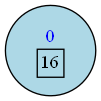



####   inserção de:  8   #####


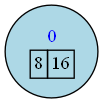



####   inserção de:  10   #####


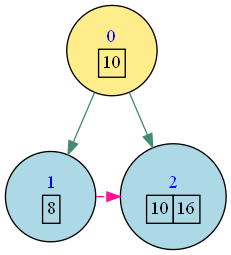



####   inserção de:  4   #####


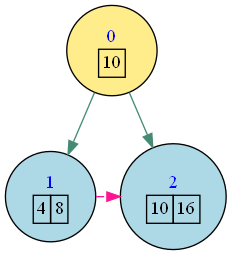



####   inserção de:  27   #####


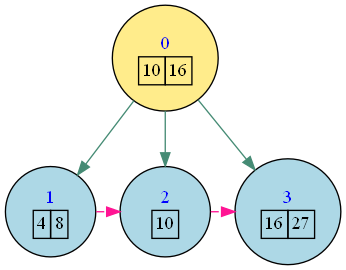



--- 0.3427469730377197 seconds ---


In [165]:
tree = cria_arv()
tree=insere_aleatoriamente(tree,3,5,1,30)

In [166]:
tree

{0: [[False, -1], [1], 10, [2], 16, [3]],
 1: [[True, 0, 2], [], 4, [], 8, []],
 2: [[True, 0, 3], [], 10, []],
 3: [[True, 0], [], 16, [], 27, []]}

## Remoção em Lote

In [64]:
def remove_aleatoriamente(d,t,n):
    global leaf_elements
    
    start_time = time.time()

    random_elements = random.sample(leaf_elements,n) #Seleciona n elementos presentes na árvore d
    print("Elementos a serem removidos: ",random_elements,"\n")
    
    for i in random_elements:
        d=exclusao(d,t,i)
        print("####   exclusao de: ", i,"  #####")
        show(d)
        print("\n")
        
    print("--- %s seconds ---" % (time.time() - start_time)) # 
    return d

Elementos a serem removidos:  [7, 24, 25] 

####   exclusao de:  7   #####


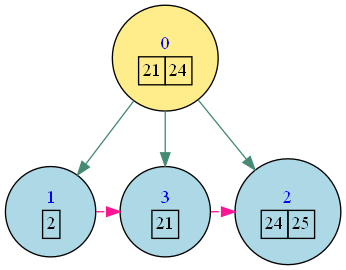



####   exclusao de:  24   #####


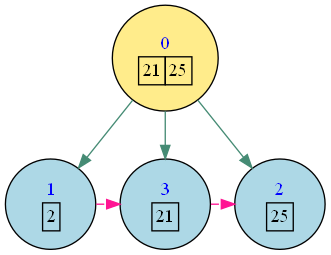



####   exclusao de:  25   #####


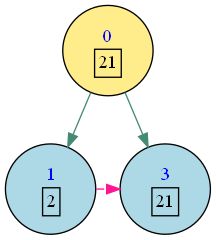



--- 0.3699958324432373 seconds ---


In [65]:
tree=remove_aleatoriamente(tree,3,3)

# Inserções Manuais

## Exemplo 1

In [66]:
tree=cria_arv()
tree = insercao(tree,3,9)
tree = insercao(tree,3,4)
tree = insercao(tree,3,50)
tree = insercao(tree,3,56)
tree = insercao(tree,3,7)
tree = insercao(tree,3,15)
tree = insercao(tree,3,12)
tree = insercao(tree,3,5)
tree = insercao(tree,3,6)
tree = insercao(tree,3,1)
tree = insercao(tree,3,2)
tree = insercao(tree,3,20)
tree = insercao(tree,3,26)
tree = insercao(tree,3,10)

In [67]:
tree

{0: [[False, -1], [1], 12, [15]],
 1: [[False, 0], [2], 6, [10]],
 2: [[False, 1], [3], 2, [11], 5, [8]],
 3: [[True, 2, 11], [], 1, []],
 4: [[True, 10, 6], [], 9, [], 10, []],
 5: [[True, 14], [], 50, [], 56, []],
 6: [[True, 7, 12], [], 12, []],
 7: [[False, 15], [6], 15, [12]],
 8: [[True, 2, 9], [], 5, []],
 9: [[True, 10, 4], [], 6, [], 7, []],
 10: [[False, 1], [9], 9, [4]],
 11: [[True, 2, 8], [], 2, [], 4, []],
 12: [[True, 7, 13], [], 15, []],
 13: [[True, 14, 5], [], 20, [], 26, []],
 14: [[False, 15], [13], 50, [5]],
 15: [[False, 0], [7], 20, [14]]}

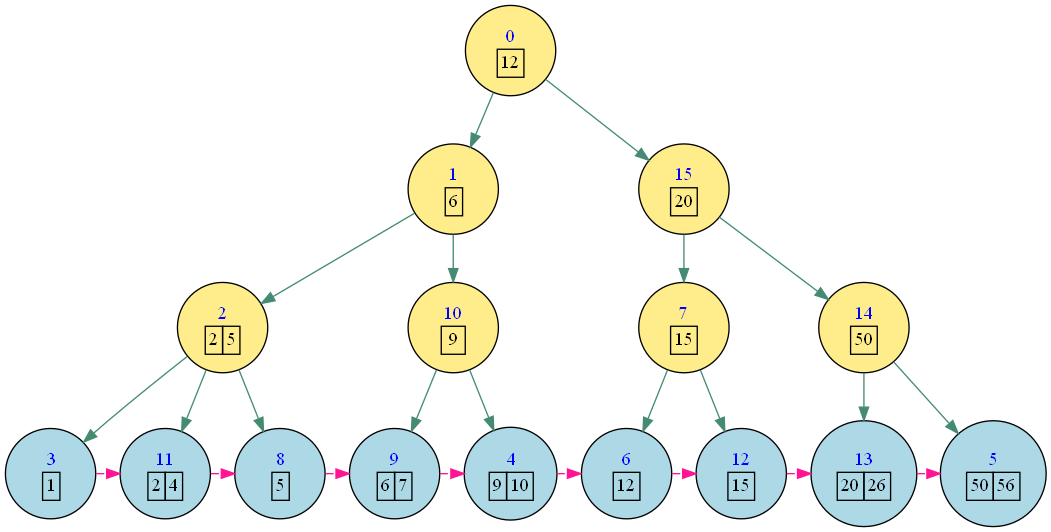

In [68]:
show(tree)

### Busca

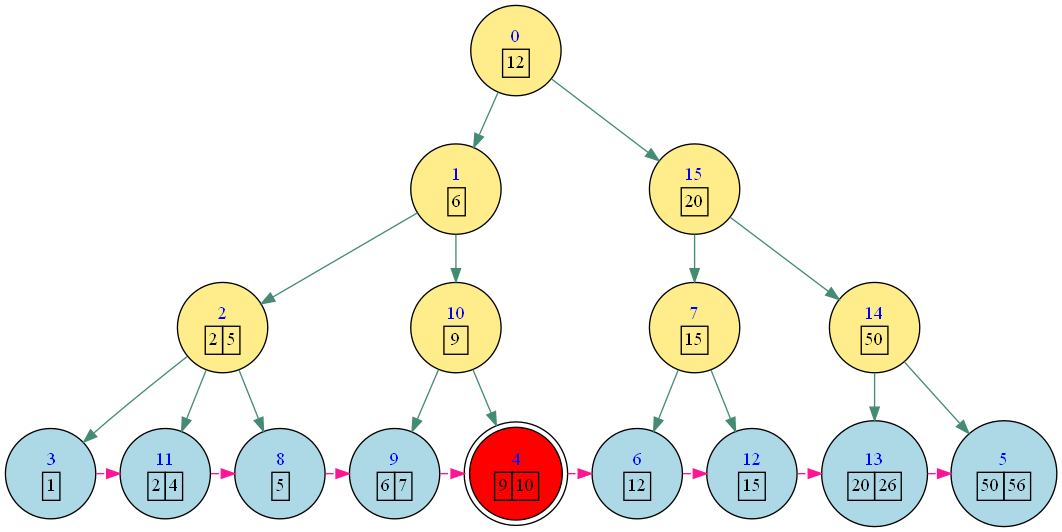

In [69]:
f=busca(tree,10)
show(tree, key=f)

## Exemplo 2

In [70]:
tree=cria_arv()
tree = insercao(tree,3,34)
tree = insercao(tree,3,78)
tree = insercao(tree,3,43)
tree = insercao(tree,3,43)
tree = insercao(tree,3,7)
tree = insercao(tree,3,19)
tree = insercao(tree,3,24)
tree = insercao(tree,3,30)
tree = insercao(tree,3,32)
tree = insercao(tree,3,69)
tree = insercao(tree,3,12)
tree = insercao(tree,3,15)
tree = insercao(tree,3,22)
tree = insercao(tree,3,5)
tree = insercao(tree,3,6)
tree = insercao(tree,3,15)
tree = insercao(tree,3,2)
tree = insercao(tree,3,20)
tree = insercao(tree,3,26)
tree = insercao(tree,3,13)

In [71]:
tree

{0: [[False, -1], [1], 24, [16]],
 1: [[False, 0], [2], 12, [15], 19, [19]],
 2: [[False, 1], [3], 6, [14]],
 3: [[True, 2, 14], [], 2, [], 5, []],
 4: [[True, 7, 5], [], 43, []],
 5: [[True, 7, 12], [], 43, []],
 6: [[True, 19, 18], [], 19, []],
 7: [[False, 16], [4], 43, [5], 69, [12]],
 8: [[True, 10, 9], [], 24, [], 26, []],
 9: [[True, 10, 11], [], 30, []],
 10: [[False, 16], [8], 30, [9], 32, [11]],
 11: [[True, 10], [], 32, [], 34, []],
 12: [[True, 7], [], 69, [], 78, []],
 13: [[True, 15, 17], [], 12, [], 13, []],
 14: [[True, 2, 13], [], 6, [], 7, []],
 15: [[False, 1], [13], 15, [17]],
 16: [[False, 0], [10], 43, [7]],
 17: [[True, 15, 6], [], 15, [], 15, []],
 18: [[True, 19], [], 20, [], 22, []],
 19: [[False, 1], [6], 20, [18]]}

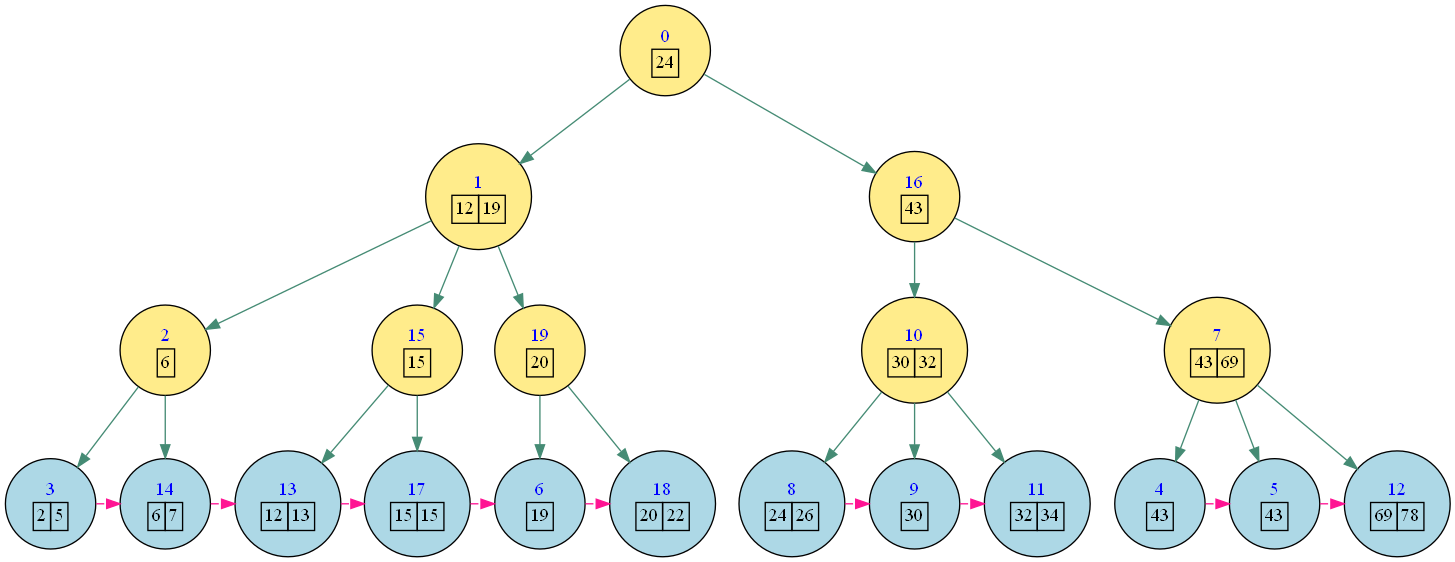

In [72]:
show(tree)

# GIF

In [73]:
def gif():
    global arvs
    lista_tree=[]
    for tree in arvs:
        dot = plot_bplus_tree(tree)  # Cria o gráfico da árvore
        image = dot.pipe(format='png')  # Gera a imagem do gráfico
        lista_tree.append(image)
    # Lista de imagens em bytes
    imagens_bytes = lista_tree  # Sua lista de imagens em bytes aqui

    # Tamanho desejado para as imagens redimensionadas
    largura = 800
    altura = 600

    # Converter bytes em objetos PIL.Image.Image e redimensionar as imagens
    imagens = []
    for imagem_bytes in imagens_bytes:
        imagem_pil = Image.open(BytesIO(imagem_bytes))
        imagem_redimensionada = imagem_pil.resize((largura, altura))
        imagens.append(imagem_redimensionada)

    # Criar um arquivo GIF temporário
    imagens[0].save('animacao.gif', format='GIF', append_images=imagens[1:], save_all=True, duration=1000, loop=0)

    # Exibir o GIF no Jupyter Notebook
    display(IPImage(filename='animacao.gif'))


In [158]:
tree=cria_arv()
tree = insercao(tree,3,9)
tree = insercao(tree,3,4)
tree = insercao(tree,3,50)
tree = insercao(tree,3,56)
tree = insercao(tree,3,7)
tree = insercao(tree,3,19)
tree = insercao(tree,3,24)
tree = insercao(tree,3,30)
tree = insercao(tree,3,32)
tree = insercao(tree,3,29)
tree = insercao(tree,3,39)
tree = insercao(tree,3,15)
tree = insercao(tree,3,12)
tree = insercao(tree,3,5)
tree = insercao(tree,3,6)
tree = insercao(tree,3,1)
tree = insercao(tree,3,2)
tree = insercao(tree,3,20)
tree = insercao(tree,3,26)
tree = insercao(tree,3,10)

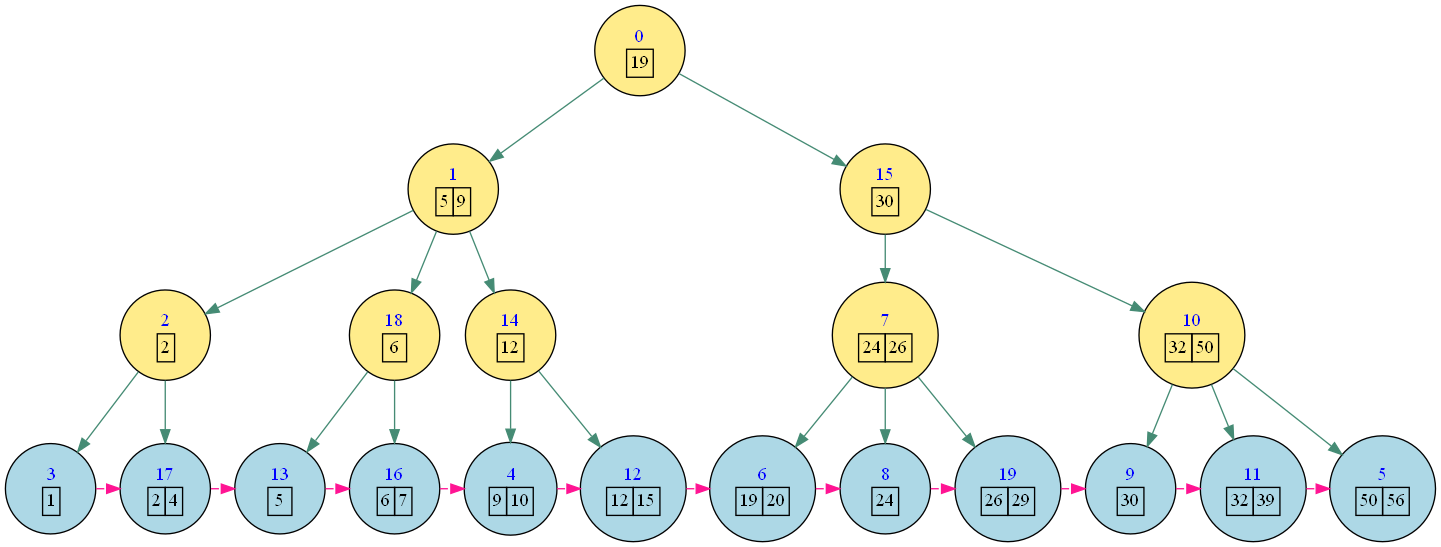

In [159]:
show(tree)

In [160]:
tree

{0: [[False, -1], [1], 19, [15]],
 1: [[False, 0], [2], 5, [18], 9, [14]],
 2: [[False, 1], [3], 2, [17]],
 3: [[True, 2, 17], [], 1, []],
 4: [[True, 14, 12], [], 9, [], 10, []],
 5: [[True, 10], [], 50, [], 56, []],
 6: [[True, 7, 8], [], 19, [], 20, []],
 7: [[False, 15], [6], 24, [8], 26, [19]],
 8: [[True, 7, 19], [], 24, []],
 9: [[True, 10, 11], [], 30, []],
 10: [[False, 15], [9], 32, [11], 50, [5]],
 11: [[True, 10, 5], [], 32, [], 39, []],
 12: [[True, 14, 6], [], 12, [], 15, []],
 13: [[True, 18, 16], [], 5, []],
 14: [[False, 1], [4], 12, [12]],
 15: [[False, 0], [7], 30, [10]],
 16: [[True, 18, 4], [], 6, [], 7, []],
 17: [[True, 2, 13], [], 2, [], 4, []],
 18: [[False, 1], [13], 6, [16]],
 19: [[True, 7, 9], [], 26, [], 29, []]}

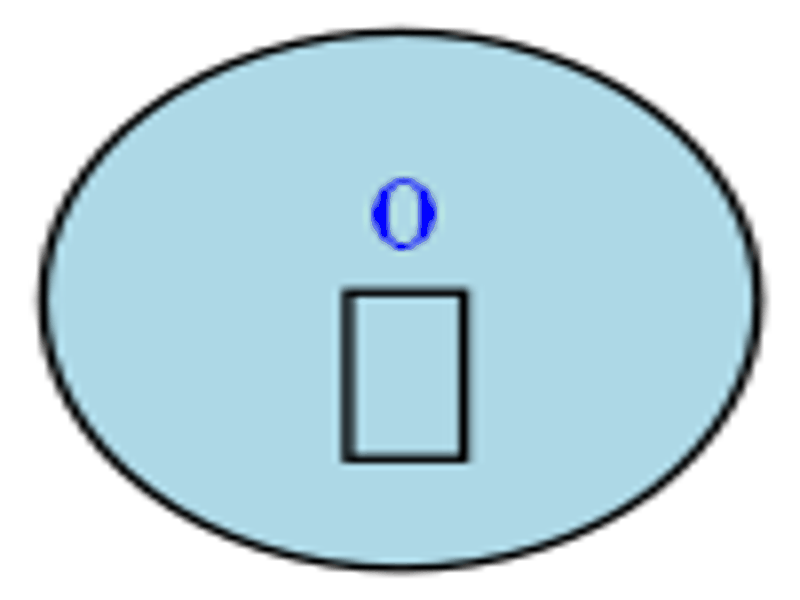

In [161]:
gif()

# Parte Interativa

In [37]:

def show_gr(tree,key=None):
    dot = plot_bplus_tree(tree,key=key)
    image = dot.pipe(format='png')
    image_pil = Image.open(BytesIO(image))
    return image_pil


def show_image_gr(tree,key=None):
    image = show_gr(tree,key=key)
    width, height = image.size
    max_width = 800  # Largura máxima desejada da imagem
    ratio = max_width / width
    new_width = max_width
    new_height = int(height * ratio)
    resized_image = image.resize((new_width, new_height))
    return resized_image




def cria_arv_gr(t):
    global grau
    global v_in
    v_in=[]
    grau=t
    global tr 
    tr= cria_arv()
  
    return show_image_gr(tr)

def insercao_gr(k):
    global cont
    global grau
    global tr 
    global t_in
    global cont_in
    
    r=cont
    
    t_in= time.perf_counter()
    tr= insercao(tr,grau,k)
    t_in = time.perf_counter()-t_in
    cont_in = cont-r
    print("##### Inserção de ",k," ####")
    print("Contador",cont_in)
    print("Timer",t_in)
    print("########################\n")
    
    image = Image.new("RGB", (50, 50), color=(255, 255, 255))
    
    # Converta a imagem para bytes
    image_bytes = io.BytesIO()
    image.save(image_bytes, format="PNG")
    image_bytes.seek(0)
  
    # Retorne a imagem
    return show_image_gr(tr)
    
    
def exclusao_gr(k):
    global cont
    global grau
    global tr
    global t_ex
    global cont_ex
    
    r=cont
    
    t_ex= time.perf_counter()
    tr = exclusao(tr,grau,k)
    t_ex = time.perf_counter()-t_ex
    cont_ex=cont-r
    print("##### Deleção de ",k," ####")
    print("Contador",cont_ex)
    print("Timer",t_ex)
    print("########################\n")
    
    return show_image_gr(tr)
def busca_gr(k):
    global tr
   
    global t_busca
    t_busca = time.perf_counter()
    t_busca = time.perf_counter()-t_busca
    
    print("##### Busca de ",k," ####")

    print("Timer",t_busca)
    print("########################\n")
    return busca(tr,k)

def mostra_gr(k):
    global tr

    f=busca(tr,k)
    return show_image_gr(tr,key=f)





def in_lote(n,minimo,maximo):
    global v_in
    global cont
    global cont_in_lote
    global tr
    global grau
    global t_in_lote
    minimo = int(minimo)
    maximo=int(maximo)
    n = int(n)
    if maximo - minimo + 1 < n:
        raise ValueError("Não é possível gerar a quantidade de números desejada no intervalo especificado.")
        
        
    numbers = random.sample(range(minimo, maximo+1), n)
    

    r=cont
    t_in_lote= time.perf_counter()
    for i in numbers:
        tr=insercao(tr,grau,i)
    t_in_lote = time.perf_counter()-t_in_lote
    cont_in_lote = cont-r

    v_in = numbers

    print("##### Inserção de ",numbers," ####")
    print("Contador",cont_in_lote)
    print("Timer",t_in_lote)
    print("########################\n")
    return show_image_gr(tr)
  





def ex_lote(n):
  
    n = int(n)
    global cont
    global cont_ex_lote
    global tr
    global grau
    global t_ex_lote
    global leaf_elements
    
    random_elements = random.sample(leaf_elements,n)
   
    r=cont
    t_ex_lote= time.perf_counter()
    for i in random_elements:
        tr=exclusao(tr,grau,i)
        
    t_ex_lote = time.perf_counter()-t_ex_lote
    cont_ex_lote = cont-r   

        
        
    print("##### Deleção de ",random_elements," ####")
    print("Contador",cont_ex_lote)
    print("Timer",t_ex_lote)
    print("########################\n")
    
    return show_image_gr(tr)

In [39]:
with gr.Blocks() as demo:

    
    
    with gr.Tab("Cria nova árvore"):
        nova_input = gr.Number(label="Grau", minimum=3, maximum=10,value=3)
        nova_button = gr.Button("Criar")
        nova_output = gr.Image()
        
        
        
    with gr.Tab("Inserção"):

        insere_input = gr.Number(label="Número a ser inserido")
        insere_button = gr.Button("Inserir")
        insere_output = gr.Image()
        
        
    with gr.Tab("Inserção Em Lote"):

        in_lote_insere = gr.Number(label="Quantidade")
        in_lote_min = gr.Number(label="Mínimo")
        in_lote_max = gr.Number(label="Máximo")
        in_lote_insere_button = gr.Button("Inserir")
        in_lote_insere_output = gr.Image()
        
        
    with gr.Tab("Exclusão"):

        exclui_input = gr.Number(label="Número a ser excluído")
        exclui_button = gr.Button("Excluir")
        exclui_output = gr.Image()
        
  
    with gr.Tab("Exclusão em Lote"):

        ex_lote_exclui = gr.Number(label="Quantidade")
        ex_lote_exclui_button = gr.Button("Excluir")
        ex_lote_exclui_output = gr.Image()

    with gr.Tab("Busca"):
        busca_input = gr.Number(label="Número a ser buscado")
        busca_button = gr.Button("Buscar")
        busca_output = gr.Textbox(label="Nó")
        f = gr.Image()
        
        



        
    nova_button.click(cria_arv_gr, inputs=nova_input,outputs=nova_output)
    
    insere_button.click(insercao_gr, inputs=insere_input, outputs=insere_output)

    
    in_lote_insere_button.click(in_lote, inputs=[in_lote_insere,in_lote_min,in_lote_max], outputs=in_lote_insere_output)

    
    
    exclui_button.click(exclusao_gr, inputs=exclui_input, outputs=exclui_output)

    
    ex_lote_exclui_button.click(ex_lote, inputs=ex_lote_exclui, outputs=ex_lote_exclui_output)

    
    
    busca_button.click(busca_gr, inputs=busca_input, outputs=busca_output)

    busca_button.click(mostra_gr, inputs=busca_input, outputs=f)

demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


##### Inserção de  23.0  ####
Contador 2
Timer 6.199999987188676e-06
########################



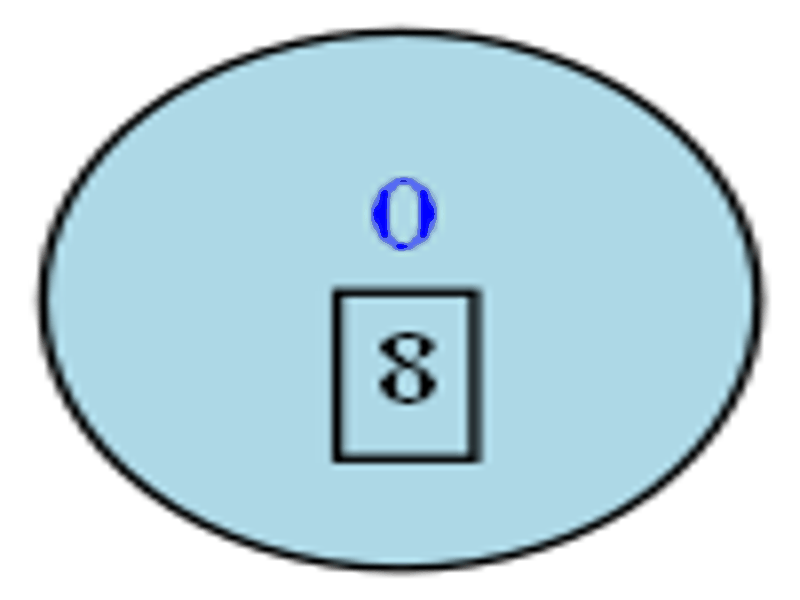

In [49]:
gif()